In [1331]:
# This is a notebook to analyse dataset for internet customers.

In [1332]:
# Local all required packages
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [1333]:
# Add function definitions
def radarplot(df, norm_max=False):
    df = df.copy()
    if norm_max:
        df /= df.max()

    angles = np.linspace(0, 2 * np.pi, len(df.columns), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # close the plot

    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)

    for i in df.index:
        stats = df.loc[i, :].values
        stats = np.concatenate((stats, [stats[0]]))  # close the plot
        ax.plot(angles, stats, 'o-', linewidth=2, label=i)
        ax.fill(angles, stats, alpha=0.25)

    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    columns = list(df.columns) + list(df.columns[:1])
    # print((angles * 180 / np.pi).shape, len(columns))
    ax.set_thetagrids(angles * 180 / np.pi, columns)
    ax.grid(True)
    return ax

In [1334]:
# Load the dataset
data = pd.read_csv("BP_DS_Challenge.csv")
data["SeniorCitizen"].replace({0: "No", 1: "Yes"}, inplace=True)
data[:5]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [1335]:
# Dataset cleaning
data['TotalCharges'] = data['TotalCharges'].replace(" ", 0)
data['SeniorCitizen']= data['SeniorCitizen'].astype(str)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])
index = pd.Index(data['customerID'].to_list())
data = data.set_index('customerID')

In [1336]:
data[:5]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [1338]:
# Extract the independent variables and save as X
X = data.iloc[:,:-1]
# Extract the dependent variable and save as Y
Y = data.iloc[:,-1]

In [1341]:
# Encode the two-value columns using LabelEncoding and the multi-value columns using OneHotEncoding
# Iterate over columns and record the columns that need LabelEncoding

two_value_categorical = []
temp = []
for i in range(data.shape[1]-1):
    col_type = str(data.dtypes[i])
    col_name = str(data.columns[i])
    col_unique_values = str(data.nunique()[i])
    encoding_type = 'NoEncoding'
    if col_type == 'object':
        if col_unique_values == '2':
            encoding_type = 'LabelEncoding'
            two_value_categorical.append(col_name)
        else:
            encoding_type = 'OneHotEncoding'
    temp.append({"col_type":col_type, "col_name":col_name, "col_unique_values": col_unique_values, "encoding_type": encoding_type})

# Encode the two-value columns using LabelEncoding
LE1 = LabelEncoder()
for col_name in two_value_categorical:
    X[col_name] = LE1.fit_transform(X[col_name])
Y = pd.DataFrame(LE1.fit_transform(Y))
pd.DataFrame.from_dict(temp)

,col_type,col_name,col_unique_values,encoding_type
0,object,gender,2,LabelEncoding
1,object,SeniorCitizen,2,LabelEncoding
2,object,Partner,2,LabelEncoding
3,object,Dependents,2,LabelEncoding
4,int64,tenure,73,NoEncoding
5,object,PhoneService,2,LabelEncoding
6,object,MultipleLines,3,OneHotEncoding
7,object,InternetService,3,OneHotEncoding
8,object,OnlineSecurity,3,OneHotEncoding
9,object,OnlineBackup,3,OneHotEncoding


In [1342]:
# Ecode all renaming columns using OneHotEncoding
X = pd.get_dummies(X)

In [1343]:
pd.DataFrame(X.columns.values)

,0
0,gender
1,SeniorCitizen
2,Partner
3,Dependents
4,tenure
5,PhoneService
6,PaperlessBilling
7,MonthlyCharges
8,TotalCharges
9,MultipleLines_No


In [1344]:
X[:1]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,0,1,0,1,0,1,29.85,29.85,0,...,1,0,0,1,0,0,0,0,1,0


In [1346]:
Y[:1]

,0
0,0


In [1347]:
X_train,X_test,Y_train,Y_test = train_test_split(X, Y,test_size=0.2,random_state=0)
X_train_Index = X_train.index.values.tolist()
X_test_Index = X_test.index.values.tolist()
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_train = np.asarray(X_train).astype(np.float32)
Y_train = np.asarray(Y_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
Y_test = np.asarray(Y_test).astype(np.float32)

In [1348]:
# Normalise the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [1349]:
pd.DataFrame(X_train[:5])

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-1.0,-0.439763,1.032476,-0.653215,1.612532,0.326254,-1.214659,0.674154,1.704761,1.035048,...,-0.806689,-0.526281,1.253566,-1.111228,-0.516093,1.793618,-0.531228,-0.518574,-0.712196,1.822238
1,-1.0,2.273954,-0.968546,-0.653215,-0.747907,-3.065099,0.823277,-0.614894,-0.709771,-0.966139,...,-0.806689,-0.526281,1.253566,0.899905,-0.516093,-0.557532,-0.531228,-0.518574,1.404108,-0.548776
2,-1.0,-0.439763,1.032476,1.530889,1.571835,0.326254,-1.214659,-1.335097,-0.208672,-0.966139,...,-0.806689,1.900125,-0.797724,-1.111228,-0.516093,1.793618,1.882432,-0.518574,-0.712196,-0.548776
3,1.0,-0.439763,1.032476,1.530889,0.025340,0.326254,0.823277,0.301578,0.053141,1.035048,...,-0.806689,-0.526281,1.253566,-1.111228,1.937635,-0.557532,-0.531228,-0.518574,-0.712196,1.822238
4,-1.0,-0.439763,1.032476,-0.653215,0.595101,0.326254,0.823277,1.128231,0.990579,-0.966139,...,1.239635,-0.526281,-0.797724,0.899905,-0.516093,-0.557532,-0.531228,-0.518574,1.404108,-0.548776


In [1351]:
ann = tf.keras.models.Sequential()

In [1352]:
ann.add(tf.keras.layers.Dense(units=50,activation="relu"))
ann.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))

In [1353]:
optimizer = tf.keras.optimizers.SGD()

In [1354]:
ann.compile(optimizer, loss="mse", metrics=["mae", "acc"])

In [1355]:
history = ann.fit(X_train,Y_train,batch_size=32,epochs = 100)

Epoch 1/100
177/177 [==============================] - 1s 2ms/step - loss: 0.1922 - mae: 0.3763 - acc: 0.7311
Epoch 2/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1563 - mae: 0.3288 - acc: 0.7792
Epoch 3/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1470 - mae: 0.3104 - acc: 0.7913
Epoch 4/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1436 - mae: 0.3000 - acc: 0.7964
Epoch 5/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1417 - mae: 0.2932 - acc: 0.7982
Epoch 6/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1405 - mae: 0.2890 - acc: 0.8000
Epoch 7/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1396 - mae: 0.2861 - acc: 0.8012
Epoch 8/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1389 - mae: 0.2837 - acc: 0.8014
Epoch 9/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1384 - mae: 0.2814 - acc: 0.8019
Epoch 10/1

177/177 [==============================] - 0s 2ms/step - loss: 0.1294 - mae: 0.2635 - acc: 0.8143
Epoch 75/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1293 - mae: 0.2640 - acc: 0.8165
Epoch 76/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1293 - mae: 0.2635 - acc: 0.8158
Epoch 77/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1291 - mae: 0.2629 - acc: 0.8154
Epoch 78/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1291 - mae: 0.2633 - acc: 0.8163
Epoch 79/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1291 - mae: 0.2628 - acc: 0.8149
Epoch 80/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1290 - mae: 0.2627 - acc: 0.8156
Epoch 81/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1289 - mae: 0.2631 - acc: 0.8154
Epoch 82/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1288 - mae: 0.2626 - acc: 0.8163
Epoch 83/100
1

In [877]:
lreg = LogisticRegression(random_state = 0)
lreg.fit(X_train, Y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=0)

In [878]:
ypred = {}
ypred["ANN"] = [x[0] for x in ann.predict(X_test)]
ypred["Regression"] = [x[1] for x in lreg.predict_proba(X_test)]

ANN
Regression


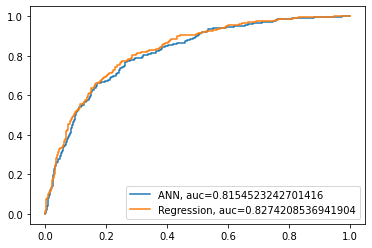

In [879]:
results = {}
for method, predictions in ypred.items():
    print(method)
    fpr, tpr, _ = metrics.roc_curve(Y_test, predictions)
    auc = metrics.roc_auc_score(Y_test, predictions)
    plt.plot(fpr,tpr,label=method + ", auc="+str(auc))
    results[method] = [str(auc)]
plt.legend(loc=4)
plt.show()

In [880]:
for method, predictions in ypred.items():
    preds = []
    for x in predictions:
        if x <= 0.5:
            preds.append(0.0)
        else:
            preds.append(1.0)
    acc = accuracy_score(Y_test, preds )
    prec = precision_score(Y_test, preds )
    rec = recall_score(Y_test, preds )
    f1 = f1_score(Y_test, preds )
    f2 = fbeta_score(Y_test, preds, beta=2.0)
    results[method] = np.concatenate((results[method], [acc, prec, rec, f1, f2]))

In [881]:
results_df = pd.DataFrame(results, index=["auc", "acc", "prec", "rec", "f1", "f2"]).transpose()

In [882]:
results_df = results_df.apply(pd.to_numeric)

In [883]:
results_df

,auc,acc,prec,rec,f1,f2
ANN,0.815452,0.797019,0.635762,0.521739,0.573134,0.541150
Regression,0.827421,0.796309,0.630225,0.532609,0.577320,0.549635


<PolarAxesSubplot:>

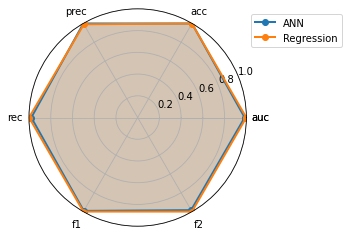

In [884]:
# Visualise the offline evaluation results
radarplot(results_df, norm_max=True)

In [885]:
without_promotion_revenue = 0
with_promotion = 0
for i, index in enumerate(X_test_Index):
    pred_churn = ypred["Regression"][i] <= 0.5
    true_churn = Y_test[i] == 1
    monthly_fee = data.loc[index][17]
    if true_churn == False:
        without_promotion_revenue += monthly_fee
    if true_churn == False and pred_churn == False:
        with_promotion += monthly_fee
    elif true_churn == True and pred_churn == True:
        with_promotion += monthly_fee*0.9
    elif true_churn == False and pred_churn == True:
        with_promotion += monthly_fee*0.9

In [886]:
print(with_promotion, without_promotion_revenue)

68411.10500000005 63279.60000000004
